Connected to analysis (Python 3.9.15)

In [1]:
from pathlib import Path
import joblib
import pandas as pd

import arviz as az

import mne
import numpy as np
from scipy.stats import zscore
from os.path import join

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from scipy.special import expit

sns.set_context('poster')

import matplotlib as mpl
new_rc_params = {'text.usetex': False,
                 "svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)


local = True

In [2]:
if local:
    home_base = '/Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus'
else:
    home_base = '/mnt/obob/staff/fschmidt/resting_tinnitus'

data_dir = join(home_base, 'data/log_reg/')#final_new_pool_3/')

trans_path = 'data/headmodels/'
mri_path = 'data/freesurfer/'
fs_path = join(home_base, mri_path, 'fsaverage')


src_file = join(fs_path, 'bem', 'fsaverage-ico-4-src.fif')
subjects_dir = join(home_base, 'data/freesurfer/')

src = mne.read_source_spaces(src_file)
labels_mne = mne.read_labels_from_annot('fsaverage', parc='HCPMMP1', subjects_dir=subjects_dir)

names_order_mne = np.array([label.name[:-3] for label in labels_mne])

rh = [True if label.hemi == 'rh' else False for label in labels_mne]
lh = [True if label.hemi == 'lh' else False for label in labels_mne]

def plot_parc(stc_parc, stc_mask, cmap, parc='HCPMMP1'):

    mpl.use('Qt5Agg')

    plot_kwargs = {
        'hemi':"split",
        'surf':"inflated",
        'views':["lateral", "medial"],
        'subjects_dir':subjects_dir,
        'cortex':[(.6,.6,.6), (.6,.6,.6)], #turn sulci and gyri to the same grey
        'background':'white',
        'offscreen':True,
        'size':(800, 400),
    }


    import nibabel as nib
    Brain = mne.viz.get_brain_class() #doesnt work directly from pysurfer

    brain = Brain("fsaverage", **plot_kwargs)

    #mask locations based on percentile
    for hemi in ["lh", "rh"]:

        annot_file = subjects_dir + f'/fsaverage/label/{hemi}.{parc}.annot'
        labels, _, nib_names = nib.freesurfer.read_annot(annot_file)

        names_order_nib = np.array([str(name)[2:-1] for name in nib_names])

        if hemi == "lh":
            names_mne = names_order_mne[lh]
            cur_stc = stc_parc[lh]#, tmin:tmax].mean(axis=1)
            cur_mask = stc_mask[lh]
        else:
            names_mne = names_order_mne[rh]
            cur_stc = stc_parc[rh]#, tmin:tmax].mean(axis=1)
            cur_mask = stc_mask[rh]

        # Create a dictionary to map strings to their indices in array1
        index_dict = {value: index for index, value in enumerate(names_mne)}

        # Find the indices of strings in array1 corresponding to array2
        right_order = [index_dict[value] for value in names_order_nib]

        cur_stc_ordered = cur_stc[right_order]
        cur_mask_ordered = cur_mask[right_order]
        
        cur_stc_ordered[cur_mask_ordered] = np.nan

        vtx_data = cur_stc_ordered[labels]
        vtx_data[labels == -1] = -1

        brain.add_data(vtx_data, hemi=hemi, fmin=stc_parc.min(), #fmid=1,
                       fmax=stc_parc.max(), 
                       colormap=cmap, #np.nanmax(stc_parc)
                       colorbar=False, alpha=.8)

    
    screenshot = brain.screenshot()
    #brain.close()
    
    return screenshot

    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    Reading a source space...
    Computing patch statistics...
    Patch information added...
    Distance information added...
    [done]
    2 source spaces read
Reading labels from parcellation...
   read 181 labels from /Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/freesurfer/fsaverage/label/lh.HCPMMP1.annot
   read 181 labels from /Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/freesurfer/fsaverage/label/rh.HCPMMP1.annot


In [3]:
feature = 'offset'
freq = 'gamma'

In [4]:
nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))

In [5]:
nc_datasets

[PosixPath('/Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/log_reg/offset_Dorsal_Stream_Visual.nc'),
 PosixPath('/Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/log_reg/offset_Early_Visual.nc'),
 PosixPath('/Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/log_reg/offset_Premotor.nc'),
 PosixPath('/Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/log_reg/offset_Temporo-Parieto-Occipital_Junction.nc'),
 PosixPath('/Users/b1059770/Library/Group Containers/G69SCX94XU.duck/Library/Application Support/duck/Volumes.noindex/bomber/resting_tinnitus/data/log_reg/offset_Orbital_and_Polar_Frontal.nc'),
 PosixPath('/Users/b1059770/Library/Group Containers/G69

In [6]:
feature = 'offset'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = [az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets]   

In [7]:
ch_effects

[                    mean     sd  hdi_5.5%  hdi_94.5%  mcse_mean  mcse_sd  \
 beta|[L_IPS1_ROI] -0.097  0.083    -0.228      0.031      0.001    0.001   
 beta|[L_V3A_ROI]  -0.109  0.083    -0.234      0.024      0.001    0.001   
 beta|[L_V3B_ROI]  -0.099  0.083    -0.230      0.028      0.001    0.001   
 beta|[L_V6A_ROI]  -0.104  0.082    -0.229      0.025      0.001    0.001   
 beta|[L_V6_ROI]   -0.103  0.084    -0.234      0.026      0.001    0.001   
 beta|[L_V7_ROI]   -0.107  0.085    -0.245      0.015      0.001    0.001   
 beta|[R_IPS1_ROI] -0.102  0.081    -0.230      0.024      0.001    0.001   
 beta|[R_V3A_ROI]  -0.100  0.082    -0.220      0.038      0.001    0.001   
 beta|[R_V3B_ROI]  -0.094  0.085    -0.224      0.038      0.001    0.001   
 beta|[R_V6A_ROI]  -0.107  0.085    -0.234      0.026      0.001    0.001   
 beta|[R_V6_ROI]   -0.096  0.085    -0.220      0.043      0.001    0.001   
 beta|[R_V7_ROI]   -0.101  0.083    -0.229      0.029      0.001    0.001   

In [8]:
pd.concat(ch_effects)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_IPS1_ROI],-0.097,0.083,-0.228,0.031,0.001,0.001,12298.0,6615.0,1.0
beta|[L_V3A_ROI],-0.109,0.083,-0.234,0.024,0.001,0.001,11745.0,6656.0,1.0
beta|[L_V3B_ROI],-0.099,0.083,-0.230,0.028,0.001,0.001,12296.0,6335.0,1.0
beta|[L_V6A_ROI],-0.104,0.082,-0.229,0.025,0.001,0.001,11819.0,6581.0,1.0
beta|[L_V6_ROI],-0.103,0.084,-0.234,0.026,0.001,0.001,12054.0,6427.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_MI_ROI],-0.099,0.059,-0.189,-0.009,0.001,0.000,10624.0,6087.0,1.0
beta|[R_PI_ROI],-0.099,0.059,-0.188,-0.008,0.001,0.000,11172.0,6529.0,1.0
beta|[R_Pir_ROI],-0.099,0.059,-0.192,-0.012,0.001,0.000,12006.0,6832.0,1.0
beta|[R_PoI1_ROI],-0.098,0.059,-0.189,-0.005,0.001,0.000,10211.0,6636.0,1.0


In [9]:
effect_order = [ix[6:-1] for ix in ch_effects.index]

reindex_array = [np.argmax(eff == names_order_mne[1:]) for eff in effect_order]

eff_mu = ch_effects['mean'].to_numpy()[reindex_array]
eff_low = ch_effects['hdi_5.5%'].to_numpy()[reindex_array]
eff_high = ch_effects['hdi_94.5%'].to_numpy()[reindex_array]

stc_parc = (np.concatenate([[eff_mu[0]], eff_mu])) / 4 #on probability scale
stc_mask_high = (np.concatenate([[eff_low[0]], eff_low])) > 0.185
stc_mask_low = (np.concatenate([[eff_high[0]], eff_high])) < -0.185
stc_mask = np.concatenate([i == False for i in [stc_mask_high + stc_mask_low]])
#stc_mask = np.zeros(stc_parc.shape) == 1
stc_mask[:2] = np.nan 

TypeError: 'builtin_function_or_method' object is not iterable

In [10]:
ch_effects = pd.concat(ch_effects)

In [11]:
effect_order = [ix[6:-1] for ix in ch_effects.index]

reindex_array = [np.argmax(eff == names_order_mne[1:]) for eff in effect_order]

eff_mu = ch_effects['mean'].to_numpy()[reindex_array]
eff_low = ch_effects['hdi_5.5%'].to_numpy()[reindex_array]
eff_high = ch_effects['hdi_94.5%'].to_numpy()[reindex_array]

stc_parc = (np.concatenate([[eff_mu[0]], eff_mu])) / 4 #on probability scale
stc_mask_high = (np.concatenate([[eff_low[0]], eff_low])) > 0.185
stc_mask_low = (np.concatenate([[eff_high[0]], eff_high])) < -0.185
stc_mask = np.concatenate([i == False for i in [stc_mask_high + stc_mask_low]])
#stc_mask = np.zeros(stc_parc.shape) == 1
stc_mask[:2] = np.nan 

IndexError: index 326 is out of bounds for axis 0 with size 296

In [12]:
effect_order

['L_IPS1_ROI',
 'L_V3A_ROI',
 'L_V3B_ROI',
 'L_V6A_ROI',
 'L_V6_ROI',
 'L_V7_ROI',
 'R_IPS1_ROI',
 'R_V3A_ROI',
 'R_V3B_ROI',
 'R_V6A_ROI',
 'R_V6_ROI',
 'R_V7_ROI',
 'L_V2_ROI',
 'L_V3_ROI',
 'L_V4_ROI',
 'R_V2_ROI',
 'R_V3_ROI',
 'R_V4_ROI',
 'L_55b_ROI',
 'L_6a_ROI',
 'L_6d_ROI',
 'L_6r_ROI',
 'L_6v_ROI',
 'L_FEF_ROI',
 'L_PEF_ROI',
 'R_55b_ROI',
 'R_6a_ROI',
 'R_6d_ROI',
 'R_6r_ROI',
 'R_6v_ROI',
 'R_FEF_ROI',
 'R_PEF_ROI',
 'L_STV_ROI',
 'L_TPOJ1_ROI',
 'L_TPOJ2_ROI',
 'L_TPOJ3_ROI',
 'R_PSL_ROI',
 'R_STV_ROI',
 'R_TPOJ1_ROI',
 'R_TPOJ2_ROI',
 'R_TPOJ3_ROI',
 'L_10d_ROI',
 'L_10pp_ROI',
 'L_11l_ROI',
 'L_13l_ROI',
 'L_47m_ROI',
 'L_47s_ROI',
 'L_OFC_ROI',
 'L_a10p_ROI',
 'L_p10p_ROI',
 'R_10d_ROI',
 'R_10pp_ROI',
 'R_11l_ROI',
 'R_13l_ROI',
 'R_47m_ROI',
 'R_47s_ROI',
 'R_OFC_ROI',
 'R_a10p_ROI',
 'R_p10p_ROI',
 'L_7AL_ROI',
 'L_7Am_ROI',
 'L_7PC_ROI',
 'L_7PL_ROI',
 'L_7Pm_ROI',
 'L_AIP_ROI',
 'L_LIPd_ROI',
 'L_LIPv_ROI',
 'L_MIP_ROI',
 'L_VIP_ROI',
 'R_7AL_ROI',
 'R_7Am_ROI',
 '

In [13]:
feature = 'exponent'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

In [14]:
ch_effects

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_52_ROI],0.184,0.079,0.063,0.303,0.001,0.001,12333.0,6669.0,1.0
beta|[L_A1_ROI],0.179,0.076,0.069,0.305,0.001,0.001,11968.0,6719.0,1.0
beta|[L_LBelt_ROI],0.177,0.076,0.060,0.294,0.001,0.001,12594.0,6843.0,1.0
beta|[L_MBelt_ROI],0.178,0.077,0.056,0.295,0.001,0.001,11615.0,6498.0,1.0
beta|[L_PBelt_ROI],0.186,0.075,0.070,0.302,0.001,0.001,12275.0,6755.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_43_ROI],0.238,0.100,0.084,0.393,0.001,0.001,9809.0,6908.0,1.0
beta|[R_FOP1_ROI],0.237,0.104,0.074,0.388,0.001,0.001,9013.0,6756.0,1.0
beta|[R_OP1_ROI],0.212,0.095,0.071,0.366,0.001,0.001,9694.0,6640.0,1.0
beta|[R_OP2-3_ROI],0.229,0.100,0.075,0.384,0.001,0.001,10148.0,7223.0,1.0


In [15]:
ch_effects['mean']

beta|[L_52_ROI]       0.184
beta|[L_A1_ROI]       0.179
beta|[L_LBelt_ROI]    0.177
beta|[L_MBelt_ROI]    0.178
beta|[L_PBelt_ROI]    0.186
                      ...  
beta|[R_43_ROI]       0.238
beta|[R_FOP1_ROI]     0.237
beta|[R_OP1_ROI]      0.212
beta|[R_OP2-3_ROI]    0.229
beta|[R_OP4_ROI]      0.239
Name: mean, Length: 202, dtype: float64

(array([24.,  5.,  4.,  0., 26., 43., 56., 26.,  0., 18.]),
 array([-0.019 ,  0.0208,  0.0606,  0.1004,  0.1402,  0.18  ,  0.2198,
         0.2596,  0.2994,  0.3392,  0.379 ]),
 <BarContainer object of 10 artists>)

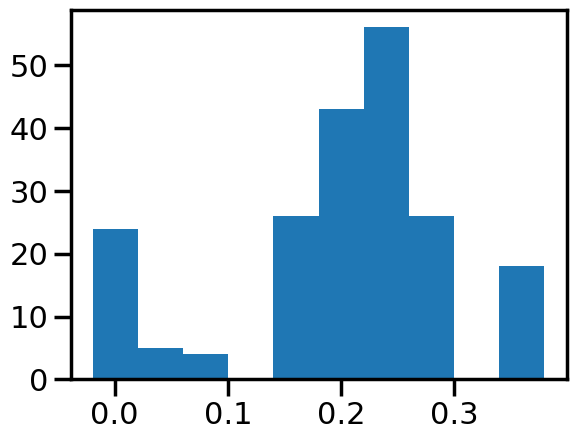

In [16]:
plt.hist(ch_effects['mean'])

In [17]:
plt.hist(ch_effects['hdi_3%'])

KeyError: 'hdi_3%'

(array([ 7., 24.,  3.,  0.,  8., 55., 14., 73.,  0., 18.]),
 array([-0.183 , -0.1376, -0.0922, -0.0468, -0.0014,  0.044 ,  0.0894,
         0.1348,  0.1802,  0.2256,  0.271 ]),
 <BarContainer object of 10 artists>)

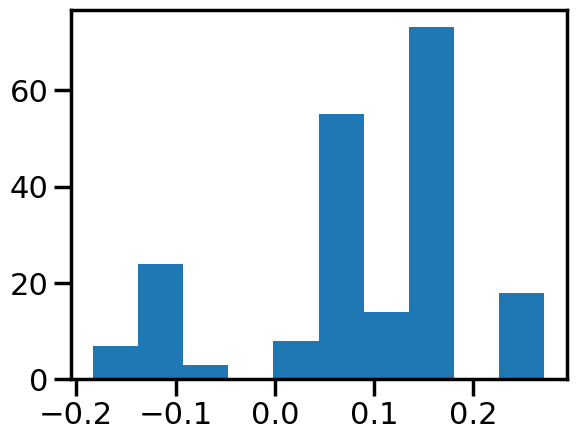

In [18]:
plt.hist(ch_effects['hdi_5.5%'])

(array([18.,  0., 11.,  4., 18., 45., 60., 19.,  8., 19.]),
 array([0.089 , 0.1294, 0.1698, 0.2102, 0.2506, 0.291 , 0.3314, 0.3718,
        0.4122, 0.4526, 0.493 ]),
 <BarContainer object of 10 artists>)

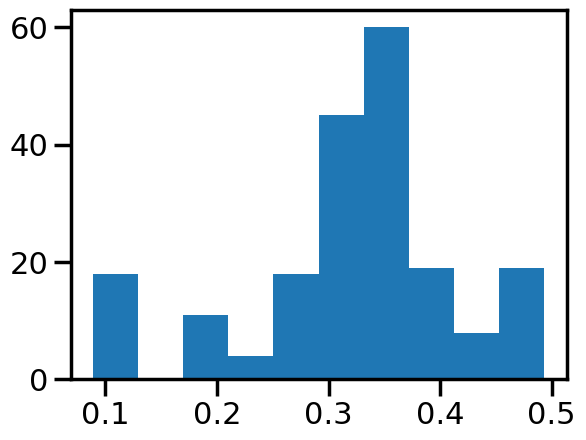

In [19]:
plt.hist(ch_effects['hdi_94.5%'])

In [20]:
feature = 'n_peaks'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

ValueError: No objects to concatenate

In [21]:
feature = 'n_peaks'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

ValueError: No objects to concatenate

In [22]:
feature = 'n_peaks'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

In [23]:
ch_effects

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_IPS1_ROI],0.029,0.174,-0.237,0.270,0.003,0.002,4684.0,6036.0,1.0
beta|[L_V3A_ROI],0.212,0.126,0.018,0.415,0.001,0.001,8514.0,6344.0,1.0
beta|[L_V3B_ROI],0.179,0.119,-0.015,0.363,0.001,0.001,10492.0,5942.0,1.0
beta|[L_V6A_ROI],0.265,0.157,0.045,0.510,0.002,0.002,5282.0,6538.0,1.0
beta|[L_V6_ROI],0.171,0.129,-0.030,0.377,0.001,0.001,10556.0,6161.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_IFJp_ROI],0.117,0.069,0.017,0.226,0.001,0.001,12548.0,6620.0,1.0
beta|[R_IFSa_ROI],0.110,0.071,0.000,0.217,0.001,0.001,13830.0,6691.0,1.0
beta|[R_IFSp_ROI],0.116,0.069,0.012,0.226,0.001,0.001,13302.0,6725.0,1.0
beta|[R_a47r_ROI],0.128,0.072,0.023,0.242,0.001,0.001,11758.0,6602.0,1.0


In [24]:
feature = 'exponent'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

In [25]:
ch_effects

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_V2_ROI],0.001,0.116,-0.175,0.187,0.001,0.001,11710.0,6860.0,1.0
beta|[L_V3_ROI],0.003,0.113,-0.171,0.179,0.001,0.001,13463.0,7131.0,1.0
beta|[L_V4_ROI],-0.001,0.113,-0.178,0.175,0.001,0.001,12358.0,7307.0,1.0
beta|[R_V2_ROI],0.013,0.112,-0.160,0.191,0.001,0.001,13562.0,6528.0,1.0
beta|[R_V3_ROI],0.004,0.111,-0.166,0.186,0.001,0.001,13085.0,6795.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_TE1p_ROI],0.188,0.073,0.076,0.304,0.001,0.001,10883.0,6927.0,1.0
beta|[R_TE2a_ROI],0.184,0.073,0.070,0.297,0.001,0.001,11221.0,6786.0,1.0
beta|[R_TE2p_ROI],0.173,0.074,0.058,0.287,0.001,0.001,10567.0,6251.0,1.0
beta|[R_TGd_ROI],0.195,0.075,0.082,0.312,0.001,0.001,11901.0,6562.0,1.0


In [26]:
ch_effects['hdi_5.5%']

beta|[L_V2_ROI]     -0.175
beta|[L_V3_ROI]     -0.171
beta|[L_V4_ROI]     -0.178
beta|[R_V2_ROI]     -0.160
beta|[R_V3_ROI]     -0.166
                     ...  
beta|[R_TE1p_ROI]    0.076
beta|[R_TE2a_ROI]    0.070
beta|[R_TE2p_ROI]    0.058
beta|[R_TGd_ROI]     0.082
beta|[R_TGv_ROI]     0.085
Name: hdi_5.5%, Length: 322, dtype: float64

(array([ 2.,  6., 35., 19., 18., 47., 69., 76.,  1., 49.]),
 array([-0.241 , -0.1898, -0.1386, -0.0874, -0.0362,  0.015 ,  0.0662,
         0.1174,  0.1686,  0.2198,  0.271 ]),
 <BarContainer object of 10 artists>)

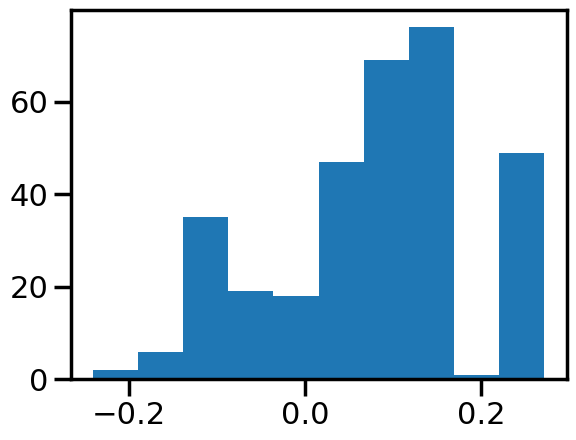

In [27]:
plt.hist(ch_effects['hdi_5.5%'])

(array([23.,  9., 24., 23., 61., 42., 65., 24., 33., 18.]),
 array([0.088 , 0.1277, 0.1674, 0.2071, 0.2468, 0.2865, 0.3262, 0.3659,
        0.4056, 0.4453, 0.485 ]),
 <BarContainer object of 10 artists>)

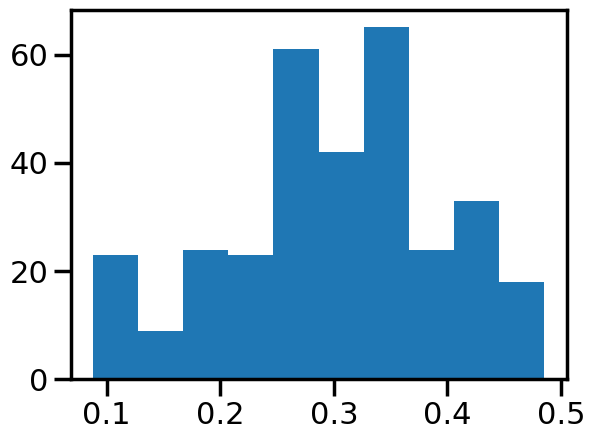

In [28]:
plt.hist(ch_effects['hdi_94.5%'])

In [29]:
feature = 'n_peaks'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

(array([18., 27., 68., 55., 22., 29., 18.,  6.,  3.,  8.]),
 array([0.087 , 0.1311, 0.1752, 0.2193, 0.2634, 0.3075, 0.3516, 0.3957,
        0.4398, 0.4839, 0.528 ]),
 <BarContainer object of 10 artists>)

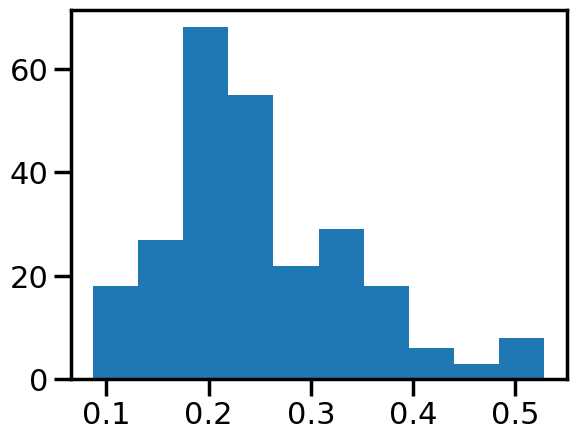

In [30]:
plt.hist(ch_effects['hdi_94.5%'])

(array([ 1.,  2.,  9., 25., 29., 33., 42., 78., 17., 18.]),
 array([-0.358 , -0.3092, -0.2604, -0.2116, -0.1628, -0.114 , -0.0652,
        -0.0164,  0.0324,  0.0812,  0.13  ]),
 <BarContainer object of 10 artists>)

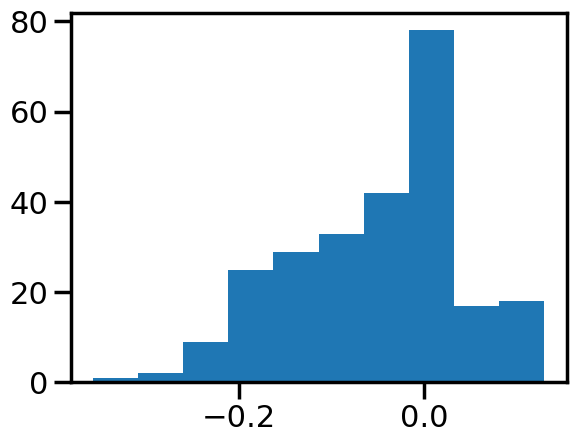

In [31]:
plt.hist(ch_effects['hdi_5.5%'])

In [32]:
feature = 'offset'
freq = 'gamma'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

(array([ 2.,  0.,  0., 37.,  4., 18., 83., 58., 31., 39.]),
 array([-0.508 , -0.4624, -0.4168, -0.3712, -0.3256, -0.28  , -0.2344,
        -0.1888, -0.1432, -0.0976, -0.052 ]),
 <BarContainer object of 10 artists>)

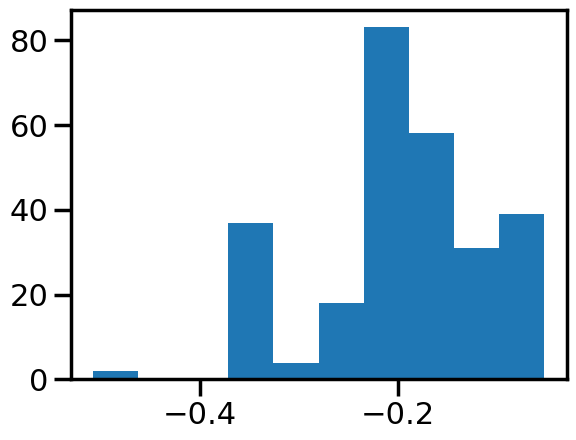

In [33]:
plt.hist(ch_effects['hdi_5.5%'])

(array([18., 13.,  5., 12., 15., 55., 46., 57., 13., 38.]),
 array([-0.131 , -0.1061, -0.0812, -0.0563, -0.0314, -0.0065,  0.0184,
         0.0433,  0.0682,  0.0931,  0.118 ]),
 <BarContainer object of 10 artists>)

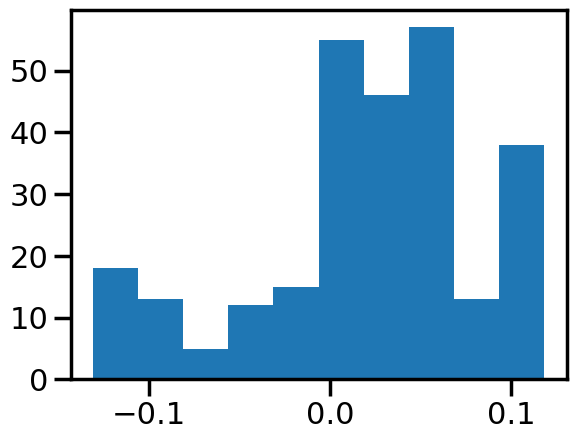

In [34]:
plt.hist(ch_effects['hdi_94.5%'])

In [35]:
feature = 'pw'
freq = 'theta'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

In [36]:
ch_effects

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_V1_ROI],-0.199,0.367,-0.752,0.412,0.004,0.004,9146.0,5919.0,1.0
beta|[R_V1_ROI],-0.530,0.547,-1.300,0.275,0.006,0.005,7674.0,5991.0,1.0
beta|[L_V2_ROI],-0.717,0.346,-1.233,-0.179,0.003,0.003,11876.0,7057.0,1.0
beta|[L_V3_ROI],-0.680,0.326,-1.183,-0.178,0.003,0.003,11302.0,6314.0,1.0
beta|[L_V4_ROI],-0.654,0.347,-1.179,-0.110,0.003,0.003,10452.0,6376.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_PFop_ROI],-0.245,0.187,-0.529,0.035,0.002,0.002,11766.0,6971.0,1.0
beta|[R_PFt_ROI],-0.190,0.183,-0.478,0.092,0.002,0.002,10896.0,5527.0,1.0
beta|[R_PGi_ROI],-0.231,0.192,-0.536,0.051,0.002,0.002,9968.0,6269.0,1.0
beta|[R_PGp_ROI],-0.218,0.189,-0.506,0.069,0.002,0.002,10518.0,6463.0,1.0


In [37]:
ch_effects

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_V1_ROI],-0.199,0.367,-0.752,0.412,0.004,0.004,9146.0,5919.0,1.0
beta|[R_V1_ROI],-0.530,0.547,-1.300,0.275,0.006,0.005,7674.0,5991.0,1.0
beta|[L_V2_ROI],-0.717,0.346,-1.233,-0.179,0.003,0.003,11876.0,7057.0,1.0
beta|[L_V3_ROI],-0.680,0.326,-1.183,-0.178,0.003,0.003,11302.0,6314.0,1.0
beta|[L_V4_ROI],-0.654,0.347,-1.179,-0.110,0.003,0.003,10452.0,6376.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_PFop_ROI],-0.245,0.187,-0.529,0.035,0.002,0.002,11766.0,6971.0,1.0
beta|[R_PFt_ROI],-0.190,0.183,-0.478,0.092,0.002,0.002,10896.0,5527.0,1.0
beta|[R_PGi_ROI],-0.231,0.192,-0.536,0.051,0.002,0.002,9968.0,6269.0,1.0
beta|[R_PGp_ROI],-0.218,0.189,-0.506,0.069,0.002,0.002,10518.0,6463.0,1.0


(array([ 1.,  2., 10., 37., 31., 27., 30., 78., 44., 30.]),
 array([-1.798 , -1.6598, -1.5216, -1.3834, -1.2452, -1.107 , -0.9688,
        -0.8306, -0.6924, -0.5542, -0.416 ]),
 <BarContainer object of 10 artists>)

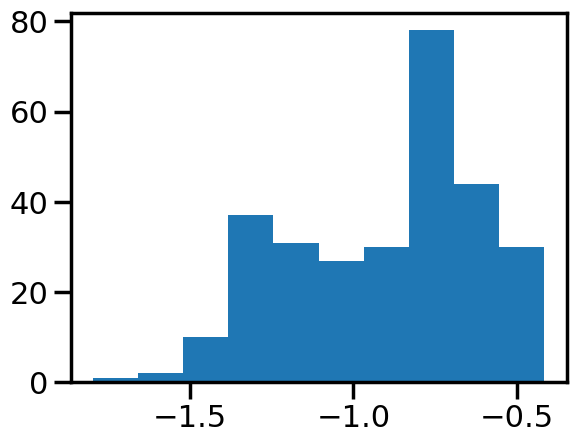

In [38]:
plt.hist(ch_effects['hdi_5.5%'])

(array([25., 23., 51., 40., 40., 46., 36., 25.,  3.,  1.]),
 array([-0.671 , -0.5627, -0.4544, -0.3461, -0.2378, -0.1295, -0.0212,
         0.0871,  0.1954,  0.3037,  0.412 ]),
 <BarContainer object of 10 artists>)

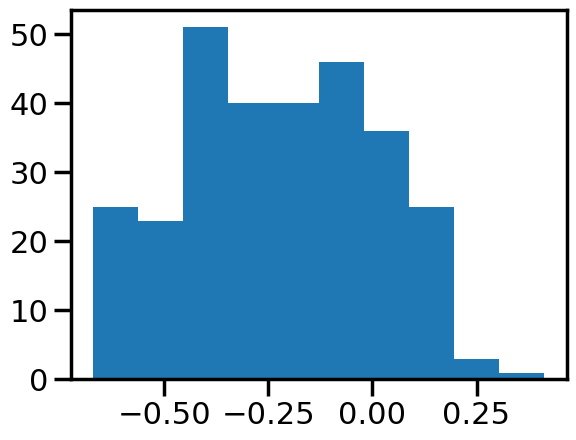

In [39]:
plt.hist(ch_effects['hdi_94.5%'])

In [40]:
feature = 'cf'
freq = 'theta'

if feature in ['exponent', 'offset', 'knee_freq', 'n_peaks']:
    #ch_effects = pd.read_csv(join(data_dir, f'{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{feature}.nc'))
else:
    #ch_effects = pd.read_csv(join(data_dir, f'{freq}_{feature}.csv'))
    nc_datasets = list(Path(data_dir).glob(f'{freq}_{feature}*.nc'))
    #mdf = az.from_netcdf(join(data_dir, f'{freq}_{feature}.nc'))

ch_effects = pd.concat([az.summary(az.from_netcdf(cur_ds), var_names='beta|', hdi_prob=.89) for cur_ds in nc_datasets])   

In [41]:
ch_effects

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta|[L_V1_ROI],-0.341,0.342,-0.871,0.215,0.003,0.003,10292.0,6592.0,1.0
beta|[R_V1_ROI],-0.405,0.366,-0.979,0.177,0.004,0.003,9433.0,6049.0,1.0
beta|[L_FFC_ROI],-0.023,0.239,-0.393,0.344,0.002,0.002,10830.0,7043.0,1.0
beta|[L_PIT_ROI],-0.042,0.210,-0.394,0.258,0.002,0.002,10875.0,6934.0,1.0
beta|[L_V8_ROI],0.020,0.252,-0.342,0.409,0.003,0.002,10146.0,5717.0,1.0
...,...,...,...,...,...,...,...,...,...
beta|[R_47m_ROI],-0.037,0.196,-0.344,0.241,0.002,0.002,10960.0,6520.0,1.0
beta|[R_47s_ROI],-0.035,0.192,-0.320,0.267,0.002,0.002,12537.0,6237.0,1.0
beta|[R_OFC_ROI],-0.090,0.182,-0.362,0.200,0.002,0.002,10770.0,5826.0,1.0
beta|[R_a10p_ROI],-0.042,0.196,-0.356,0.234,0.002,0.002,11204.0,6930.0,1.0


(array([ 8., 30., 40., 49., 38., 47., 41., 18.,  4.,  5.]),
 array([-0.252 , -0.1686, -0.0852, -0.0018,  0.0816,  0.165 ,  0.2484,
         0.3318,  0.4152,  0.4986,  0.582 ]),
 <BarContainer object of 10 artists>)

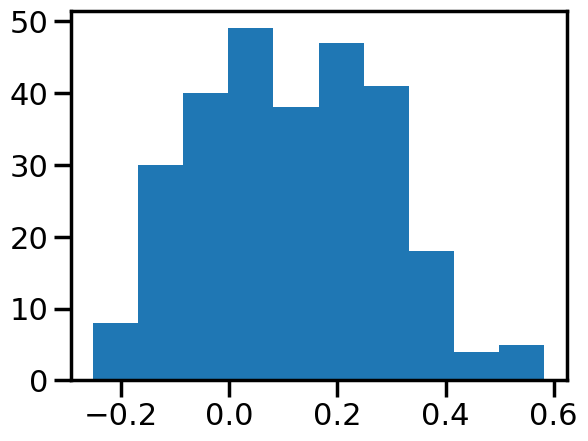

In [42]:
plt.hist(ch_effects['hdi_94.5%'])